<img src="FIGURES/GIGGLES_FALL_2017.001.jpeg" />

<img src="FIGURES/GIGGLES_FALL_2017.002.jpeg" />

<img src="FIGURES/GIGGLES_FALL_2017.003.jpeg" />

<img src="FIGURES/GIGGLES_FALL_2017.004.jpeg" />

<img src="FIGURES/GIGGLES_FALL_2017.005.jpeg" />

<img src="FIGURES/GIGGLES_FALL_2017.006.jpeg" />

<img src="FIGURES/GIGGLES_FALL_2017.007.jpeg" />

<img src="FIGURES/GIGGLES_FALL_2017.008.jpeg" />

<img src="FIGURES/GIGGLES_FALL_2017.009.jpeg" />

<img src="FIGURES/GIGGLES_FALL_2017.010.jpeg" />

# Hydroseismology Data Processing 
Let's process some ambient noise data! 

In [1]:
# import modules 
# python modules 
import sys
import os 
import glob 
from datetime import datetime 

# array, numerical and plotting modules 
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import pandas as pd 

# seismology module
import obspy 


In [2]:
# load raw data using Obspy
RIO = "/Users/thclements/Desktop/GIGGLES_DATA/RIO"
RIO_mseed = os.path.join(RIO,"*.mseed")
RUS = "/Users/thclements/Desktop/GIGGLES_DATA/RUS"
RUS_mseed = os.path.join(RUS,"*.mseed")

st1 = obspy.read(RIO_mseed)
st2 = obspy.read(RUS_mseed)

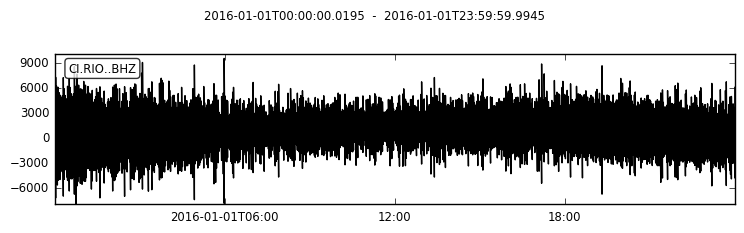

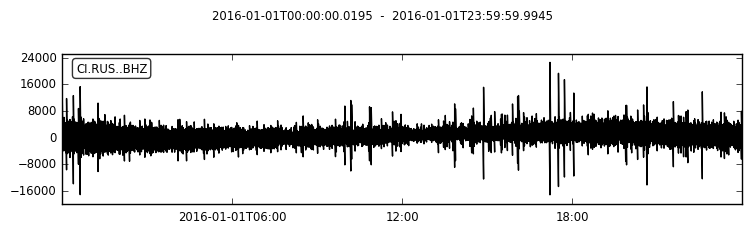

In [3]:
# plot waveforms 
tr1 = st1[0]
tr2 = st2[0]
t1,t2 = tr1.stats.starttime,tr1.stats.endtime
t3,t4 = tr2.stats.starttime,tr2.stats.endtime
t1,t2 = np.max([t1,t3]),np.min([t2,t4])
tr1,tr2 = tr1.slice(t1,t2),tr2.slice(t1,t2)
tr1.plot()
tr2.plot()

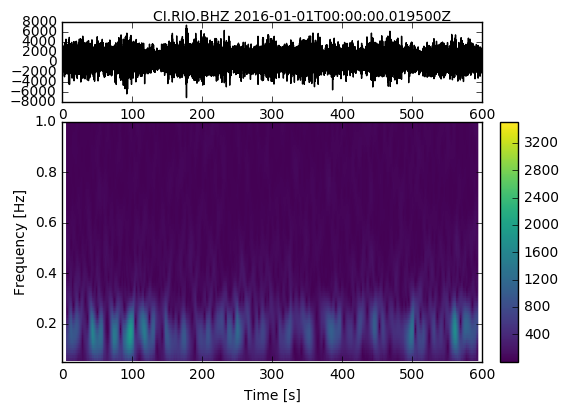

In [5]:
# plot spectrogram 
sys.path.append('/Users/thclements/odyssey')
from tools import spect
spect(tr1.copy().slice(t1,t1+600),fmin = 0.05,fmax=1.)
    
